M3FD

hr (fused gt)
* mean = [0.5053627490997314, 0.5096102356910706, 0.4942591190338135]
* std = [0.16396358609199524, 0.16512036323547363, 0.17756418883800507]

lr (original RGB)
* mean = [0.5030222535133362, 0.5073319673538208, 0.4919067621231079]
* std = [0.18895170092582703, 0.19339631497859955, 0.20666654407978058]

ir
* mean = [0.32962000370025635, 0.32962000370025635, 0.32962000370025635]
* std = [0.19771261513233185, 0.19771261513233185, 0.19771261513233185]

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

hr_path = '/home/allen/Documents/MIE288/sr3_server4/data/fuse/m3fd_detect_320_240/hr'
lr_path = '/home/allen/Documents/MIE288/sr3_server4/data/fuse/m3fd_detect_320_240/lr'
ir_path = '/home/allen/Documents/MIE288/sr3_server4/data/fuse/m3fd_detect_320_240/ir'

# hr_path = '/home/allen/Documents/MIE288/sr3_server4/data/fuse/m3fd_fusion_320_240/hr'
# lr_path = '/home/allen/Documents/MIE288/sr3_server4/data/fuse/m3fd_fusion_320_240/lr'
# ir_path = '/home/allen/Documents/MIE288/sr3_server4/data/fuse/m3fd_fusion_320_240/ir'

hr_files = [p for p in Path('{}'.format(hr_path)).glob(f'**/*')]
hr_files=sorted(hr_files, key=lambda i: int(i.stem))

lr_files = [p for p in Path('{}'.format(lr_path)).glob(f'**/*')]
lr_files=sorted(lr_files, key=lambda i: int(i.stem))

ir_files = [p for p in Path('{}'.format(ir_path)).glob(f'**/*')]
ir_files=sorted(ir_files, key=lambda i: int(i.stem))

In [2]:
# mean_hr = [0, 0, 0]
# std_hr = [1, 1, 1]

# mean_lr = [0, 0, 0]
# std_lr = [1, 1, 1]

# mean_ir = [0, 0, 0] 
# std_ir = [1, 1, 1]

mean_hr = [0.5, 0.5, 0.5]
std_hr = [0.16, 0.16, 0.17]

mean_lr = [0.5, 0.5, 0.5]
std_lr = [0.19, 0.19, 0.21]

mean_ir = [0.33]
std_ir = [0.2]

transform_hr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_hr, std_hr)
])

transform_lr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_lr, std_lr)
])

transform_ir = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_ir, std_ir)
])

In [3]:
def to_tensor_and_normalize(files, mode):
    img_ls = []
    for file in tqdm(files):
        img = Image.open(file).convert('RGB')
        if mode == 'HR':
            img = transform_hr(img)
        elif mode == 'LR':
            img = transform_lr(img)
        elif mode == 'IR':
            img = transform_ir(img)
        img_ls.append(img)
    img_ls = torch.stack(img_ls, 0)

    return img_ls

In [4]:
hr_imgs = to_tensor_and_normalize(hr_files, 'HR')
lr_imgs = to_tensor_and_normalize(lr_files, 'LR')
ir_imgs = to_tensor_and_normalize(ir_files, 'IR')

100%|██████████| 4200/4200 [00:14<00:00, 293.96it/s]


In [5]:
def find_y_avg(imgs):
    y_list = []
    
    for i in tqdm(range(imgs.shape[0])):
        y = 0.299*imgs[i,0,:,:] + 0.587*imgs[i,1,:,:] + 0.114*imgs[i,2,:,:]
        y_avg = np.average(y)
        y_list.append(y_avg)
    
    return np.array(y_list)

In [6]:
def calculate_mean_std(imgs):

    mean_ls = []
    std_ls = []
    
    channels = imgs.shape[1]

    for i in tqdm(range(channels)):
        all_pixels = imgs[:,i,:,:]
        
        std, mean = torch.std_mean(all_pixels)

        mean_ls.append(mean.item())
        std_ls.append(std.item())
    
    return mean_ls, std_ls
    

In [16]:
mean_hr, std_hr = calculate_mean_std(hr_imgs)
print(mean_hr)
print(std_hr)

mean_lr, std_lr = calculate_mean_std(lr_imgs)
print(mean_lr)
print(std_lr)

mean_ir, std_ir = calculate_mean_std(ir_imgs)
print(mean_ir)
print(std_ir)

100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


[0.033517222851514816, 0.060064028948545456, -0.03376983106136322]
[1.0247724056243896, 1.0320022106170654, 1.0444952249526978]


100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


[0.01590670831501484, 0.03858921676874161, -0.038539305329322815]
[0.994482696056366, 1.01787531375885, 0.9841264486312866]


100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

[-0.0019000438041985035, -0.0019000438041985035, -0.0019000438041985035]
[0.988563060760498, 0.988563060760498, 0.988563060760498]


In [8]:
hr_y = find_y_avg(hr_imgs)
lr_y = find_y_avg(lr_imgs)
ir_y = find_y_avg(ir_imgs)

100%|██████████| 4200/4200 [00:01<00:00, 4135.63it/s]


In [9]:
hr_sample = hr_imgs[0].permute(1,2,0).numpy()
lr_sample = lr_imgs[0].permute(1,2,0).numpy()
ir_sample = ir_imgs[0].permute(1,2,0).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


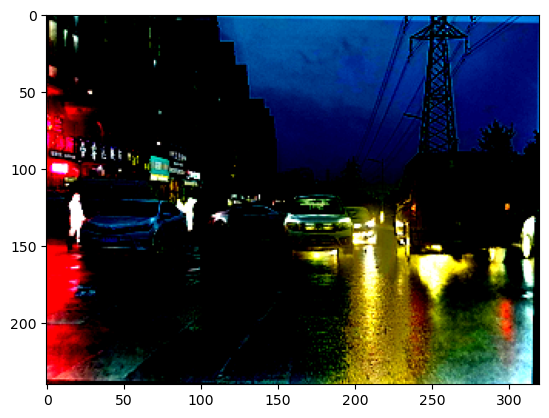

In [10]:
plt.imshow(hr_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


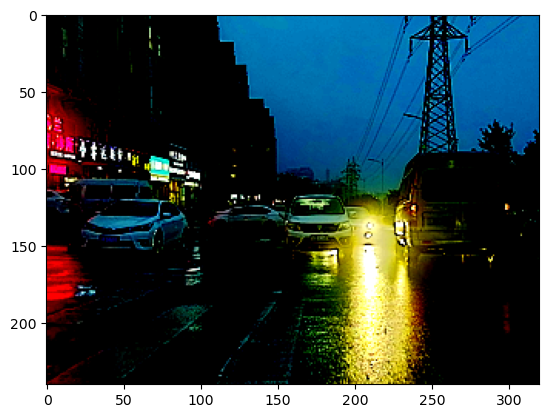

In [11]:
plt.imshow(lr_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


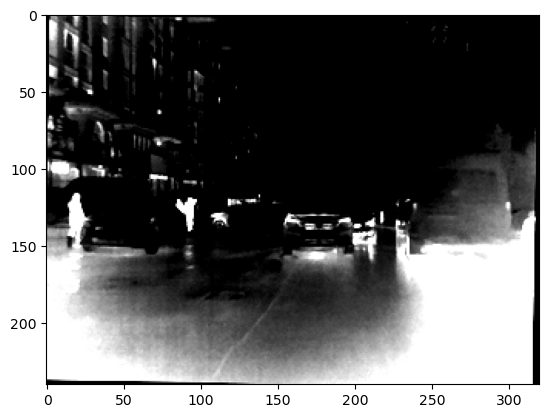

In [12]:
plt.imshow(ir_sample)

Text(0.5, 1.0, 'Y distribution of HR imgs')

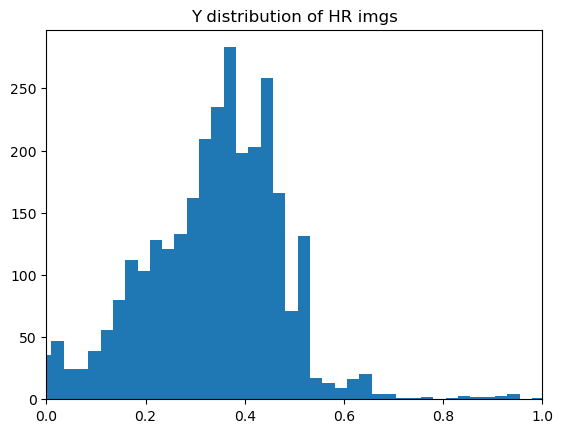

In [17]:
plt.hist(hr_y, bins=100)
plt.xlim(0, 1)
plt.title('Y distribution of HR imgs')


Text(0.5, 1.0, 'Y distribution of LR imgs')

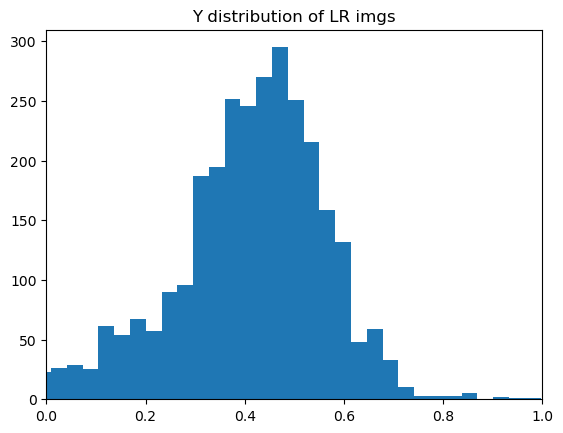

In [18]:
plt.hist(lr_y, bins=100)
plt.xlim(0, 1)
plt.title('Y distribution of LR imgs')

Text(0.5, 1.0, 'Y distribution of IR imgs')

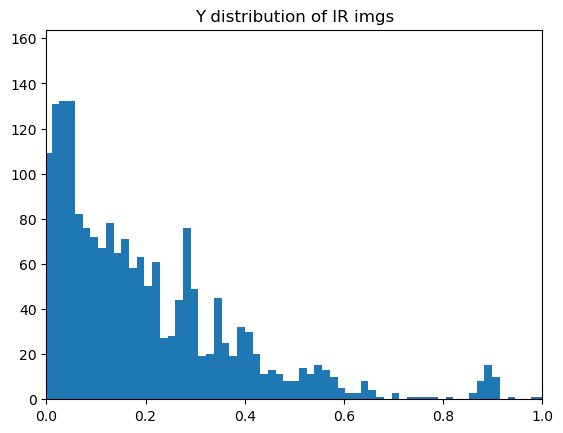

In [19]:
plt.hist(ir_y, bins=100)
plt.xlim(0, 1)
plt.title('Y distribution of IR imgs')